In [34]:
import numpy as np
from ARMA import ARMA
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from tqdm import tqdm

In [25]:
case = 'chb01'
sset = 'Test'
fe = 'AR'
modelroot = './models' + '/' + case + '/' + fe


root = './data' + '/' + sset + '/' + case
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_files = ['chb01_06_interictal.npy', 'chb01_07_interictal.npy', 'chb01_08_interictal.npy']
preictal_files = ['chb01_16_preictal.npy', 'chb01_18_preictal.npy', 'chb01_26_preictal.npy']

In [9]:
interictal_data = []
preictal_data = []
for i in tqdm(range(3)):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files[i]
    data = np.load(filepath)
    interictal_data.append(data)
    del data
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files[i]
    data = np.load(filepath)
    preictal_data.append(data)
    del data

100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


In [18]:
interictal_input = np.hstack(interictal_data)
preictal_input = np.hstack(preictal_data)
print('Interictal:', interictal_input.shape, 'Preictal:', preictal_input.shape)
X = np.hstack((interictal_input, preictal_input))
print('All:', X.shape)

Interictal: (23, 691203) Preictal: (23, 691203)
All: (23, 1382406)


In [26]:
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

modelname = 'chb01_AR_SVM_Linear'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Model: chb01_AR_SVM_Linear
Input length: 1382406
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [33]:
# online prediction
fp = fs/N                                                # Prediction frequency
t_s = 1/fs                                               # Input signal time period

a_k_list = []                                              # Sequential buffer for  MA samples
a_h_k_list = []                                            # Sequential buffer for AR signal samples
k_list = []                                                # Sequential buffer for time index in prediction point _k
preds = []

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                   # Initialise AR coefficients
c = m * np.ones(m)                               # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Streaming'): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels
        
        # classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)        
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
k = np.array(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)

Streaming: 100%|██████████| 1381892/1381892 [00:12<00:00, 109161.62it/s]


In [42]:
prediction_sig = np.hstack(preds)
prediction_sig.shape

(2699,)

In [62]:
t = np.arange(0, X.shape[1]) / fs
X_mean = np.mean(X, axis=0)
X_mean.shape

(1382406,)

In [80]:
t_preictal = np.rint(np.max(np.arange(0, interictal_input.shape[1]) / fs))
print('Preictal start time:', t_preictal)

Preictal start time: 2700.0


In [56]:
k = np.hstack(k_list)
pt = np.arange(0, k.shape[0]) / (256/512)

In [70]:
ar_mean = np.mean(a_h_k, axis=1)
ar_mean.shape

(2699, 2)

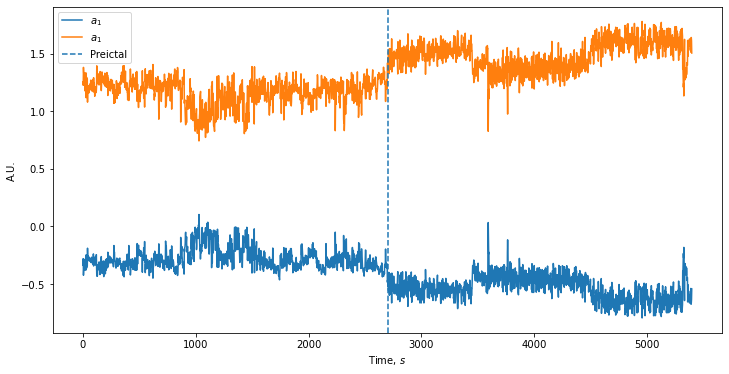

In [81]:
plt.figure(figsize=(12,6))

palette = sns.color_palette('Set2', n_colors=2)
sns.lineplot(x=pt, y=ar_mean[:,0], label='$a_1$')
sns.lineplot(x=pt, y=ar_mean[:,1], label='$a_1$')

plt.axvline(x=t_preictal, ls='--', label='Preictal')
plt.xlabel('Time, $s$')
plt.ylabel('A.U.')
plt.legend()
plt.show()

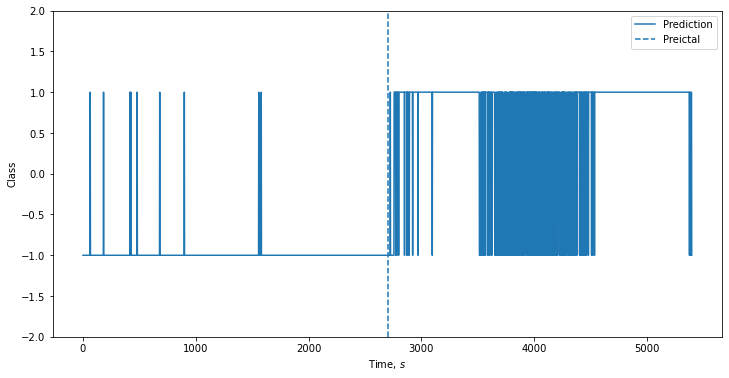

In [82]:
plt.figure(figsize=(12,6))

palette = sns.color_palette('Set2', n_colors=2)
ax = sns.lineplot(x=pt, y=prediction_sig, label='Prediction', palette=['red'])

plt.axvline(x=t_preictal, ls='--', label='Preictal')
plt.ylim([-2,2])
plt.xlabel('Time, $s$')
plt.ylabel('Class')
plt.legend()
plt.show()